# The Non Random Two Liquids (NRTL) model for *excess Gibbs energy* ($g^E$) in a case study of Liquid-Liquid equilibria of Ethyl acetate (1) + water (2) + ethanol (3) --  the  scipy verified numerical methods approach

Having discussed Excess properties, the NRTL model specifically, and VLE,
Having successfully discussed LLE
A parentheses to discuss the verified scipy numerical methods approach

# Requirements

# The NumPy package
for array structures and operations

In [2]:
import numpy as np

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
from scipy.constants import R

# scipy optmization package

In [5]:
from scipy import optimize as opt

# The NRTL model
as presented in previous lecture

reproduced below in minimalist numpy/numba format

In [6]:
from numba import jit
@jit
def Gamma(T,c_x,q_alpha, q_A):
    q_tau     = q_A/T
    q_G       = np.exp(-(q_alpha*q_tau))
    l_D       = ((1/((q_G.T) @ c_x)).T)
    q_E       = (q_tau*q_G) * l_D 
    gamma     = np.exp(((q_E+(q_E.T))-(((q_G * l_D) * (c_x.T)) @ (q_E.T))) @ c_x)
    return gamma

# fited parameters
 
 Renon and Prausnitz, 1969

In [7]:
# Ethyl acetate (1) + water (2) + ethanol (3)

alpha12 = 0.4

alpha23 = 0.3

alpha13 = 0.3

# 6 binary Aij parameters
Dg12 = 1335 * 4.184 #J/K
Dg21 = 2510 * 4.184 #J/K

Dg23 = 976 * 4.184 #J/K
Dg32 = 88 * 4.184 #J/K

Dg13 = 301 * 4.184 #J/K
Dg31 = 322 * 4.184 #J/K

## Feeding the fitted parameters to the model in matrix structure:
we will assemble the parameters in a matrix structure compatible with the current imlementation of the model

In [17]:
#assemble matrix with regressed parameters Dg_i,j, according to the model all diagonal terms are zero
Dg = np.array([[0, Dg12, Dg13],
             [Dg21, 0, Dg23],
             [Dg31, Dg32, 0]])


#assemble symmetric matrix alpha
alpha = np.array([[0, alpha12, alpha13],
                [alpha12, 0, alpha23],
                [alpha13, alpha23, 0]])

A= Dg/R

In [18]:
T = 273+70 #K

# Liq-Liq Equilibria Flash
already discussed

# initial guess


In [19]:
#Estimativas Iniciais

def iguess(Z,MODEL):
    #print(Z)
    X0 = Z
    gama0 = MODEL(X0)
    
    Xlin = 1/(gama0.T @ Z) * (gama0*Z)

    gamalin = MODEL(Xlin)

    Klin = (1./gamalin) * gama0

    KlinMin = np.min(Klin)
    KlinMax = np.max(Klin)

    nI0 = (KlinMax - Klin) * Z

    XI0 = 1/(np.sum(nI0)) * nI0

    gamaI0=MODEL(XI0)

    nII0=(Klin-KlinMin) * Z

    XII0=1/(np.sum(nII0)) * nII0;

    gamaII0=MODEL(XII0)

    beta0 = np.array([[ 1/(KlinMax-KlinMin) * np.sum(nII0) ]])
    
    K0 = (gamaI0)/(gamaII0)

    return beta0, K0

# algorithm


In [29]:
def ELLflash_sci(Z,beta0,K0,MODEL):
        
    #prepare FP input
    def fix(kxixiibeta):
        #local varaibles translation
        K=np.array([kxixiibeta[0:3]]).T
        beta0 = np.array([[kxixiibeta[9]]])
        
        #prepare NR input
        F = lambda beta, K=K, Z=Z: (Z.T @ ((1/(1+beta*(K-1))) * (K-1)))
        J = lambda beta, K=K, Z=Z: -(((Z.T*((1/(1+beta*(K-1))) * (K-1)).T) @ ((1/(1+beta*(K-1))) * (K-1))))
        
        #run NR
        beta = opt.newton(func=F,x0=beta0,fprime=J,tol=1e-4, maxiter=100)
        
        #run XI, gammaI, XII, gammaII
        XI = (1./(1+beta * (K-1))) * Z
        gamaI = MODEL(XI/np.sum(XI))
        XII = K*XI
        gamaII = MODEL(XII/np.sum(XII))
        
        #prepare return-format solution
        return np.concatenate( ( ((gamaI)/(gamaII))[0:,0], XI[0:,0], XII[0:,0], beta[0:,0] ), axis=0 )
    
    #prepare FP input
    point0 = np.concatenate( ( K0[0:,0], np.zeros(3), np.zeros(3), beta0[0:,0] ), axis=0 )

    #sanity check
    if np.isnan(point0).any() or np.isinf(point0).any():
        print('nans or infs here')
        raise ValueError
    
    #run FP    
    point = opt.fixed_point(func = fix, x0 = point0, xtol=1e-04, maxiter=100,method='iteration')
    
    #prepare return-format solution
    K = np.array([point[0:3]]).T
    XI = np.array([point[3:6]]).T
    XII = np.array([point[6:9]]).T
    beta = np.array([point[9:10]]).T
    converged=1
    
    return XI, XII, beta, converged

In [31]:
#test

#exact ad-hoc NRTL solution
#Ztest = np.array([[ 0.10526316,  0.84210526,  0.05263158]]).T
#XItest = np.array([[ 0.02616646,  0.93009914,  0.0437344 ]]).T
#XIItest = np.array([[ 0.51520944,  0.38604626,  0.0987443 ]]).T
#BETAtest = np.array([[ 0.16173772]])

#appproximate
Ztest = np.array([[ 0.1,  0.85,  0.05]]).T
XItest = np.array([[ 0.025,  0.93,  0.045 ]]).T
XIItest = np.array([[ 0.5,  0.39,  0.11 ]]).T
BETAtest = np.array([[ 0.16]])


Ktest=1/(XItest/XIItest)

beta0=BETAtest
k0=Ktest
Z=Ztest

MODEL = lambda x: Gamma(T,x,alpha,A)

#beta0, k0 = iguess(Z,MODEL)

In [32]:
ans=ELLflash_sci(Z,beta0,k0,MODEL)

print('at T', T, 'Z', Z.T)
print('with ig of k0', k0.T,'beta0', beta0)
print('solution is')
print('xi',ans[0].T)
print('xii',ans[1].T)
print('beta',ans[2])
print('converged?',ans[3], '-- 1 means yes')

at T 343 Z [[ 0.1   0.85  0.05]]
with ig of k0 [[ 20.           0.41935484   2.44444444]] beta0 [[ 0.16]]
solution is
xi [[ 0.02558461  0.93242124  0.04199415]]
xii [[ 0.5230632   0.38142227  0.09551452]]
beta [[ 0.14958511]]
converged? 1 -- 1 means yes


# grid calc plot

In [101]:
MODEL = lambda x: Gamma(T,x,alpha,A)

nspace = 400

#Z0 = np.array([0.1  , 0.85 , 0.05]).T
Z0 = np.array([0.4  , 0.55 , 0.05]).T

ig = iguess(Z0,MODEL)

print(ig)

Zs = np.ndarray((nspace), dtype=object)

flags = np.zeros((nspace))

npts = nspace

Resultados_beta = np.zeros([npts])
Resultados_conv = np.zeros([npts])
Resultados_Z = np.zeros([npts,3])
Resultados_XI = np.zeros([npts,3])
Resultados_XII = np.zeros([npts,3])

Zs[0]=Z0

beta0, K0 = iguess(np.array([Zs[0]]).T,MODEL)

l=0
for k in range(npts):
    #print(beta0,K0)
    #print(Zs[k],beta0,K0)
    #try:
    print('try,',k)
    print(Zs[k],beta0,K0)
    ans = ELLflash_sci(np.array([Zs[k]]).T,beta0,K0,MODEL)
    print('done')
    #succeeds:

    if (0<ans[2] and 1>ans[2] and ans[3]!=0):
        #print(ans[0][0][0],ans[0][1][0],ans[0][2][0])
        #print(ans[0][0:3,0])
        Resultados_XI[l,:] = ans[0][0:3,0]#np.array([ans[0][0][0],ans[0][1][0],ans[0][2][0]])
        Resultados_XII[l,:] = ans[1][0:3,0] #np.array([ans[1][0][0],ans[1][1][0],ans[1][2][0]])
        Resultados_beta[l] = ans[2]
        Resultados_conv[l] = ans[3]

        Resultados_Z[l,:] = Zs[k]
        
        #print('l++')
        
        
        print(Zs[k])

        x=Zs[k][2]
        y=Zs[k][1]            

        print(ans[0])
        print(ans[0][0:3,0])
        Resultados_XI[l,:] = ans[0][0:3,0]
        print(Resultados_XI[l,:])
        print(Resultados_XII[l,:])

        print(Resultados_XI[l,:])

        vec = Resultados_XII[l,:] - Resultados_XI[l,:]

        print(vec)

        d=.001

        w1=d
        w2 = vec[2]*w1/vec[1]

        x=x-w1
        y=y-w2
        z=1-y-x
        Zs[k+1]=[z,y,x]

        print('next')
        print(Zs[k+1])
        print(np.sum(Zs[k+1]))
        beta0=ans[2].copy()
        K0=ans[1]/ans[0]

        print (beta0)
        print(K0)

        l+=1
    else:
        raise deuruim

#    except RuntimeError:
        #print('no converge here')
#        pass
#    except ValueError:
        #print('no c(onverge here')).copy()
#        pass
#    finally:
        #print('k++')
#        pass
    
        
print('done',l)
ndone=l
    






(array([[ 0.41754485]]), array([ 48.18333263,   0.07151391,   1.70569721]))
try, 0
[ 0.4   0.55  0.05] [[ 0.41754485]] [[ 48.18333263]
 [  0.07151391]
 [  1.70569721]]
done
[ 0.4   0.55  0.05]
[[ 0.02070142]
 [ 0.95331031]
 [ 0.02598826]]
[ 0.02070142  0.95331031  0.02598826]
[ 0.02070142  0.95331031  0.02598826]
[ 0.60471403  0.33232642  0.06295955]
[ 0.02070142  0.95331031  0.02598826]
[ 0.58401261 -0.6209839   0.03697129]
next
[0.40094046336628036, 0.55005953663371965, 0.049000000000000002]
1.0
[[ 0.64946984]]
[[ 29.21122901]
 [  0.34860256]
 [  2.42261501]]
try, 1
[0.40094046336628036, 0.55005953663371965, 0.049000000000000002] [[ 0.64946984]] [[ 29.21122901]
 [  0.34860256]
 [  2.42261501]]
done
[0.40094046336628036, 0.55005953663371965, 0.049000000000000002]
[[ 0.0205481 ]
 [ 0.95400594]
 [ 0.02544595]]
[ 0.0205481   0.95400594  0.02544595]
[ 0.0205481   0.95400594  0.02544595]
[ 0.60724622  0.33097925  0.06177453]
[ 0.0205481   0.95400594  0.02544595]
[ 0.58669811 -0.62302669  0

RuntimeError: Failed to converge after 100 iterations, value is [  7.35434164e+03   3.72375500e-03   2.41683263e+00   1.91521997e-04
   1.17073745e+00  -1.70928971e-01   1.40875860e+00   4.35971712e-03
  -4.13118322e-01   5.61837375e-01]

* of a grid with 210 points we foundo solutions for 28 points
* lets soon see wether we tried calculations at conditions that do not have solution, or at conds that had solutions but our algorithms missed

# note we have 28 convergences here with scipy, before we had 33 convergences,
# therefore scipy missed 5 more points with solution than before
# note however in the plots below tha scipy' algorithm was able to converge 1 calculation closer to the critical point than before!
# we can tweak scipy options and use better methods provided by scipy

In [102]:
ndone=100

In [103]:
fResultados_XI = Resultados_XI[:][np.where(Resultados_conv!=0)]
fResultados_XII = Resultados_XII[:][np.where(Resultados_conv!=0)]
fResultados_beta = Resultados_beta[np.where(Resultados_conv!=0)]
fResultados_Z = Resultados_Z[:][np.where(Resultados_conv!=0)]

In [104]:
# barycentric coords: (a,b,c)
a=fResultados_XI[:,0]
b=fResultados_XI[:,1]
c=fResultados_XI[:,2]

d=fResultados_XII[:,0]
e=fResultados_XII[:,1]
f=fResultados_XII[:,2]

g=fResultados_Z[:,0]
h=fResultados_Z[:,1]
ii=fResultados_Z[:,2]



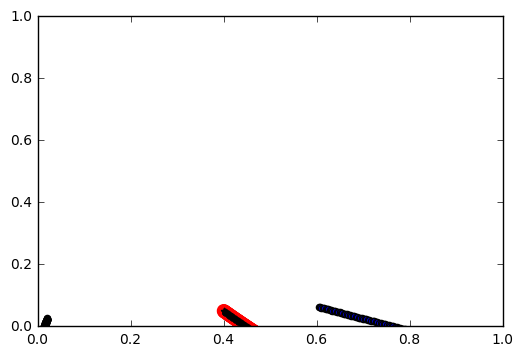

In [105]:
plt.axis([0,1,0,1])
    
plt.scatter(a,c)    
plt.scatter(d,f)    

ZS=np.zeros([npts,3])
for i in range(npts):
    ZS[i,:]=Zs[i]

plt.scatter(ZS[:,0],ZS[:,2],marker='o',s=80, facecolors='none', edgecolors='r')    
    
plt.scatter(g,ii,marker='*')

#UNCOMMENT THIS LINE TO PLOT THE FAILED POINT
#failedpoint= [0.42105263 , 0.52631579 , 0.05263158]
#plt.scatter(bug[0],bug[2],marker='d')

plt.show()

In [106]:
# x crit = 0.2 aprox


#refiltrar a e b LEFT and RIGHT of the crit point

crit=.2

al=a[np.where(a<=crit)]
ar=a[np.where(a>crit)]
dl=d[np.where(d<=crit)]
dr=d[np.where(d>crit)]

bl=b[np.where(a<=crit)]
br=b[np.where(a>crit)]
el=e[np.where(d<=crit)]
er=e[np.where(d>crit)]

cl=c[np.where(a<=crit)]
cr=c[np.where(a>crit)]
fl=f[np.where(d<=crit)]
fr=f[np.where(d>crit)]

In [107]:
Ly = np.concatenate((al,dl),axis=0)
Lx = np.concatenate((cl,fl),axis=0)

Ry = np.concatenate((ar,dr),axis=0)
Rx = np.concatenate((cr,fr),axis=0)

sLy=np.sort(Ly)
sLx=np.sort(Lx)
sRy=np.sort(Ry)
sRx=-np.sort(-Rx)

print(a.shape,b.shape,d.shape,e.shape)
print(al.shape,bl.shape,dl.shape,el.shape)
print(ar.shape,br.shape,dr.shape,er.shape)
print(Ly.shape,Ry.shape,Lx.shape,Rx.shape)


(357,) (357,) (357,) (357,)
(357,) (357,) (0,) (0,)
(0,) (0,) (357,) (357,)
(357,) (357,) (357,) (357,)


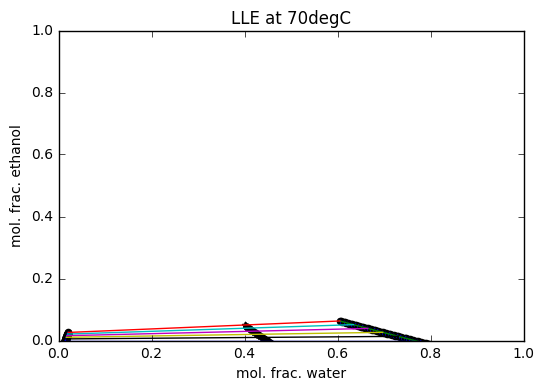

In [109]:
plt.axis([0,1,0,1])
    
plt.scatter(Ly,Lx)    
plt.scatter(Ry,Rx)    

plt.plot(sLy,sLx)
plt.plot(sRy,sRx)


for i in range(0,ndone,10):
    plt.plot([a[i],d[i]],[c[i],f[i]])


plt.scatter(g,ii, marker='*')

plt.xlabel('mol. frac. water')
plt.ylabel('mol. frac. ethanol')
plt.title('LLE at '+str(T-273)+'degC')    
    
plt.show()
